In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from pyspark.mllib.stat import Statistics
%matplotlib inline

import findspark
findspark.init()

# Import and start a Spark session.
from pyspark.sql import *
import pyspark.sql.functions as F

spark = SparkSession.builder.getOrCreate()
plt.rcParams['figure.figsize'] = [12, 8]

# Analyze of hashtags as a whole

The first part of our work is the analysis of how hashtags behave. Here, we want to understand the general behavior. A more precise analyse on specific hashtags will come latter.

## Creating our datasets

As the twitter dataset is huge, we can't work directly on it, we must find a way to extract insights from it that are usefull from our analysis. We are particularly interested in two metrics: 
- the count of tweets having a given hashtag
- the exposure (which we are calling "print") of tweets having a given hashtag. The exposure of a tweet is defined as an approximation of the audience reached by it, which is approximately the number of followers of the author. Then, we can approximate the exposure of several tweets by the sums of the followers of every authors. This is an over approximation as some users could have common followers, but it should be good enough.

Then, for each hashtag $h$ we are extracting the following insights:
- the total count of tweets having the hashtag $h$
- for each day the total count of tweets having the hashtag $h$ and tweeted on this day
- the exposure of tweets having the hashtag $h$
- for each day the exposure of tweets having the hashtag $h$ and tweeted on this day

More concretely, we ran the script `hashtag_insights.py` for each month on the cluster. Then, we merged the insights of different months as explained below.

### Merging of monthly insights into an insights dataframe.

We start by loading our monthly insights extracted from the cluster. We load every month of 2017 at the exception of:
- January, as we never managed to open it on the cluster
- June, as it contain nearly no data on the cluster
- December as it was absent of the cluster

In [26]:
def load_insights(months):
    return {month: spark.read.parquet('hashtags_insights_{}.parquet'.format(month)) for month in months} 

hashtags = load_insights(['02', '03', '04', '05', '07', '08', '09', '10', '11'])

For reasons we didn't understood, our hashtags insights for the month of augusts contained some duplicates rows. Hence, we remove them before continuing our analysis.

In [ ]:
hashtags['08'] = hashtags['08'].dropDuplicates()

For each monthly hashtags, some days could be absent (which is the case for the month of November where the 19th, 20th, 21st, 22nd, 23rd, 24th and 25th are missing). We remove the corresponding rows. For rows that still exists we prefix them. As rows `count` and `print` can be recomputed easily, to avoid any conflicts when joining the monthly insights we remove them.

In [ ]:
def rename_columns(insights, prefix):
    printCols = [c for c in insights.columns if "print_" in c]
    nameCols = [c for c in insights.columns if "count_" in c]
    print(insights, prefix)
    for x in printCols + nameCols:
        if insights.where(F.col(x) != 0).count() == 0:
            insights = insights.drop(x)
        else:
            insights = insights.withColumnRenamed(x, prefix + "_" + x)
    return insights.drop("count").drop("print")

In [ ]:
insights = [rename_columns(hashtags[key], key) for key in hashtags]

We now join every monthly hashtags by using an outer join.

In [ ]:
from functools import reduce

def joinAll(dfs):
    return reduce(lambda prev, cur: cur.join(prev, on='tag', how='outer'), dfs)

In [ ]:
unifiedInsights = joinAll(insights)

We then replace Nan entries by 0 and we recompute rows `count` and `print`.

In [ ]:
unifiedInsights = unifiedInsights.fillna(0).cache()
count_columns = [c for c in unifiedInsights.columns if "count" in c]
unifiedInsights = unifiedInsights.withColumn("count", sum(F.col(c) for c in count_columns))
print_columns = [c for c in unifiedInsights.columns if "print" in c]
unifiedInsights = unifiedInsights.withColumn("print", sum(F.col(c) for c in print_columns))

Finally we export this dataset to a parquet file.

In [ ]:
unifiedInsights.write.mode("overwrite").parquet("hashtags-insights.parquet")

### Building a "compressed insights" from our insights.

For convenience, we also decided to build a new dataset from the previous one. The main difference is in how we store the count per day and the print per day. In the previous dataset we had one column per day for the count and the exposure. In the one we will be building, we will have a row which will be an array of counts, and a row which will be an array of exposure (the ith entry maps to day i). These arrays will be relative to the row count and print, that is normalized between 0 and 1. This allows us to compare the behavior of two hashtags more accurately.

In [27]:
insights = spark.read.parquet("hashtags-insights.parquet")

We first build a time-sorted list of names of columns corresponding to a hashtag count. We also build the equivalent for the exposure.

In [28]:
def key(c):
    """ Parse a column name of the form month_(print|count)_day in a tuple (month, day)"""
    month, _, day = c.split("_")
    return int(month), int(day)


count_columns_wkey = [(c, key(c)) for c in insights.columns if "count_" in c]
count_columns_wkey.sort(key=lambda x: x[1])
count_columns = [a for a, _ in count_columns_wkey]
count_days = [b for _, b in count_columns_wkey]

print_columns_wkey = [(c, key(c)) for c in insights.columns if "print_" in c]
print_columns_wkey.sort(key=lambda x: x[1])
print_columns = [a for a, _ in print_columns_wkey]
print_days = [b for _, b in print_columns_wkey]

We create a new column `count_daily` which will be the array of normalized daily counts and drop the columns that have become useless.

In [ ]:
insights_compressed = \
    insights \
    .withColumn("count_daily", F.array(*[F.col(c) / F.col('count') for c in count_columns])) \
    .select(*[c for c in insights_compressed.columns if not c in count_columns])

We know do the same to add `print_daily`, which is the equivalent of `count_daily` but for the exposure.

In [ ]:
insights_compressed = \
    insights_compressed \
    .withColumn("print_daily", F.array(*[F.col(c) / F.col('print') for c in print_columns])) \
    .select(*[c for c in insights_compressed.columns if not c in print_columns])

Then we export the resulting dataset to a parquet file.

In [ ]:
insights_compressed.write.parquet("insights-compressed.parquet")

## Analysis of hashtags insight

In [ ]:
We start by loading our two datasets:

In [10]:
corr_mat=Statistics.corr(features, method="pearson")

In [12]:
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = count_columns, count_columns

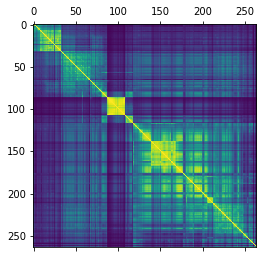

In [13]:
plt.matshow(corr_mat)

In [19]:
features = insights.where(F.col('count') > 100).select(count_columns).rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="spearman")

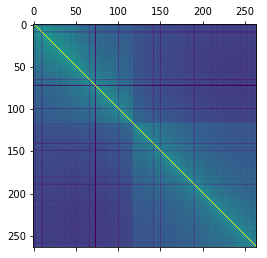

In [20]:
plt.matshow(corr_mat)

In [22]:
count_days[90:110]

[(5, 4),
 (5, 5),
 (5, 6),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (5, 11),
 (5, 12),
 (5, 13),
 (5, 14),
 (5, 15),
 (5, 16),
 (5, 17),
 (5, 18),
 (5, 19),
 (5, 20),
 (5, 21),
 (5, 22),
 (5, 23)]

In [ ]:
features = insights.where(F.col('print') > 100).select(print_columns).rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")

In [11]:
insights.count()

15177260

In [15]:
insights.where(F.col('count') > 1).count()

5888031

In [16]:
insights.where(F.col('count') > 100).count()

257434

In [17]:
bins, counts = insights.where(F.col('count') > 100) \
        .select(F.log10('count')).rdd \
        .flatMap(lambda x: x) \
        .histogram(100)

Text(0, 0.5, 'Number of occurences')

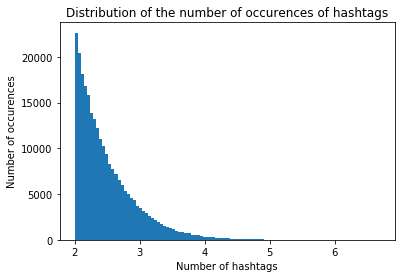

In [19]:
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of the number of occurences of hashtags' )
plt.xlabel('Number of hashtags')
plt.ylabel('Number of occurences')

In [30]:
bins, counts = insights.where(F.col('print') > 1000) \
        .select(F.log10('print')).rdd \
        .flatMap(lambda x: x) \
        .histogram(100)

Text(0, 0.5, 'Number of occurences')

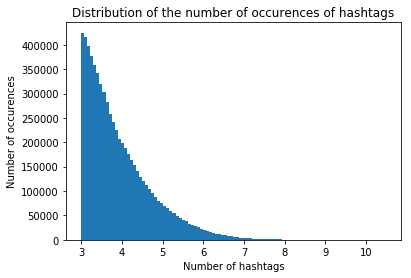

In [31]:
plt.hist(bins[:-1], bins=bins, weights=counts)
plt.title('Distribution of the number of occurences of hashtags' )
plt.xlabel('Number of hashtags')
plt.ylabel('Number of occurences')

In [32]:
test = insights.where(F.col('count') > 100).toPandas()

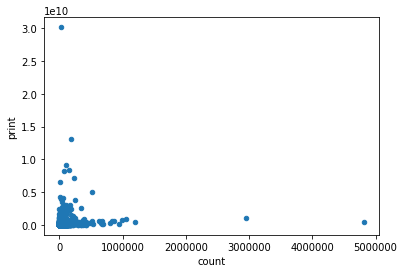

In [34]:
test.plot.scatter(x="count", y="print")

In [37]:
test.sort_values("count", ascending=False).head()

,tag,11_print_1,11_print_2,11_print_3,11_print_4,11_print_5,11_print_6,11_print_7,11_print_8,11_print_9,...,02_count_21,02_count_22,02_count_23,02_count_24,02_count_25,02_count_26,02_count_27,02_count_28,count,print
193708,izmirescort,683095,1173665,495435,449088,605584,305955,68561,41577,66398,...,4916,7339,5696,5451,4886,4517,5264,6686,4813484,473402849
181676,BTSBBMAs,313285,8747,286921,13567,253865,54084,12916,4770,8963,...,0,0,0,0,0,0,0,0,2943069,1054566200
181942,MTVHottest,48775,35054,44860,69997,41356,52917,29678,42271,34500,...,89,86,99,98,57,35,34,46,1188991,408684695
256291,BTS,4667800,2774639,6995572,4675435,1901820,2946446,1844329,2342752,1958604,...,2632,4931,6164,5951,4760,5391,4229,2911,1048438,856258406
253669,방탄소년단,5333705,3708412,6501709,5048843,3176814,3018128,1925205,2081661,1854240,...,3190,5655,11064,9037,7407,8583,4950,3238,992185,805900903


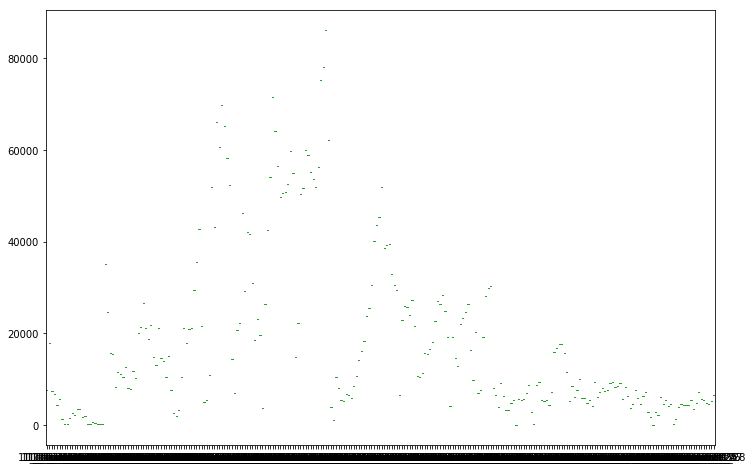

In [50]:
columns = [c for c in test.columns if "count_" in c]
test[test.tag=="izmirescort"].boxplot(columns, grid=False)